# ИССЛЕДОВАНИЕ ДАННЫХ HR-АГЕНТСТВА
HR-агентство изучает тренды на рынке труда в IT. Компания хочет провести исследование на основе данных о зарплатах в сфере Data Science за 2020–2022 годы и получить некоторые выводы

Исследуйте данные и сделайте выводы по полученным результатам. Подкрепите свои рассуждения и выводы визуализациями и с помощью статистического тестирования проверьте, являются ли выводы статистически значимыми.

В процессе своего анализа вы должны:

1. Выяснить, какие факторы влияют на зарплату специалиста Data Scientist.
2. А также ответить на ключевые вопросы HR-агентства:
    * Наблюдается ли ежегодный рост зарплат у специалистов Data Scientist?
    * Как соотносятся зарплаты Data Scientist и Data Engineer в 2022 году?
    * Как соотносятся зарплаты специалистов Data Scientist в компаниях различных размеров?
    * Есть ли связь между наличием должностей Data Scientist и Data Engineer и размером компании?

Если вы найдёте в данных интересные закономерности, также отметьте их в своём анализе.

Продемонстрируйте использование разных тестов для проверки статистической значимости сделанных выводов:
* тесты для количественного признака:
    * для одной выборки;
    * для двух выборок;
    * для нескольких выборок;
* тест для категориальных признаков.

In [1]:
import pandas as pd
import numpy as np

from scipy import stats
import statsmodels.api as sm
from statsmodels import stats as sms

import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

sns.set_theme("notebook") 
sns.set_palette("Set2")

plt.rcParams['figure.figsize'] = (12, 8) 

### Описание столбцов
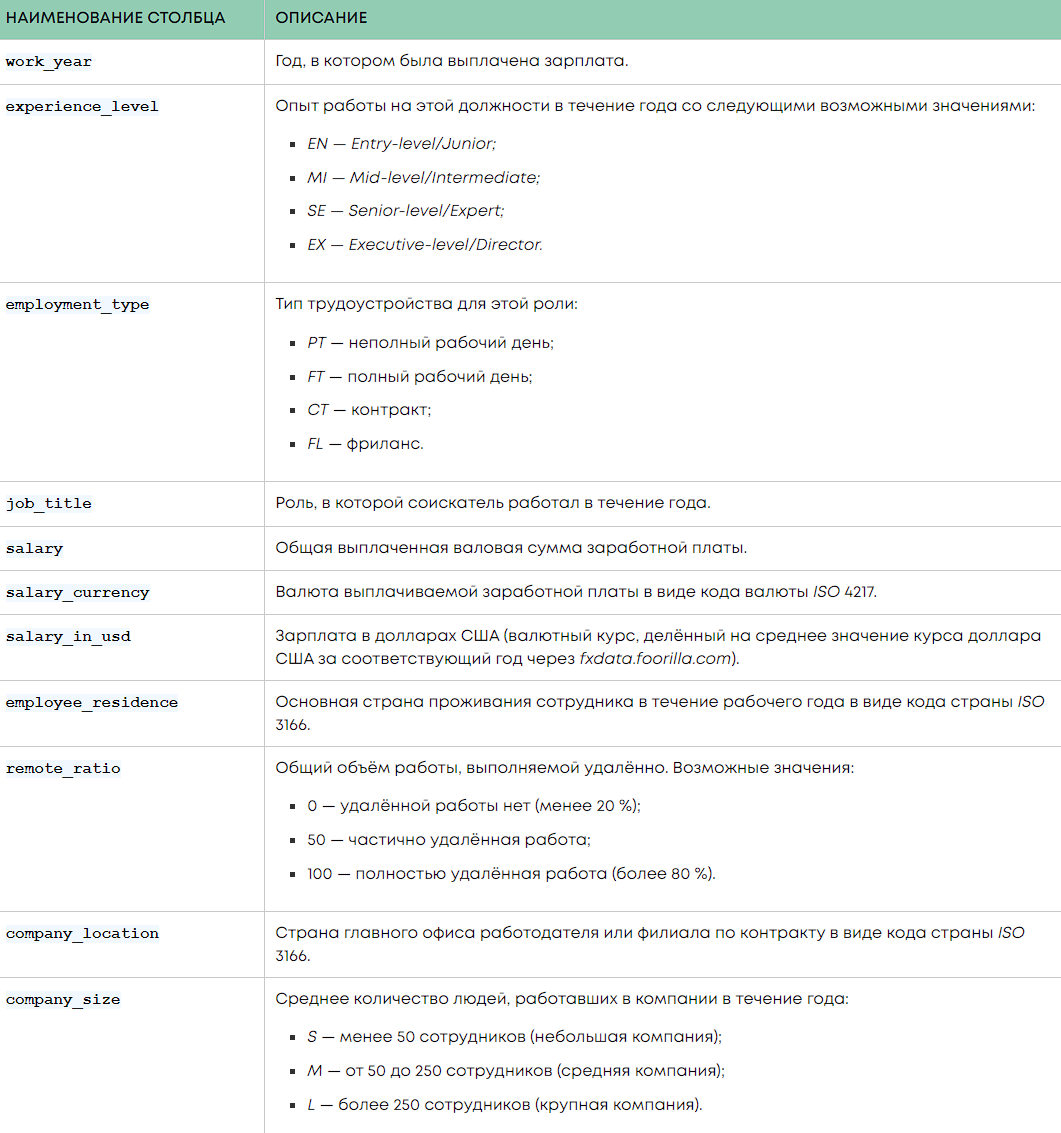

# 1. Загрузка и обработка данных

In [2]:
df = pd.read_csv('data/ds_salaries.zip', index_col=0)
df

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L
...,...,...,...,...,...,...,...,...,...,...,...
602,2022,SE,FT,Data Engineer,154000,USD,154000,US,100,US,M
603,2022,SE,FT,Data Engineer,126000,USD,126000,US,100,US,M
604,2022,SE,FT,Data Analyst,129000,USD,129000,US,0,US,M
605,2022,SE,FT,Data Analyst,150000,USD,150000,US,100,US,M


### Поиск пропусков и дубликатов

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


явных пропусков не обнаружено

In [4]:
dublicate_mask = df.duplicated()
print(f'Обнаружено {dublicate_mask.sum()} дубликатов')

df = df.drop_duplicates().reset_index(drop=True)

Обнаружено 42 дубликатов


дубликаты удалены

### Статистки в разрезе числовых и категориальных признаков

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
work_year,565.0,2021.364602,6.981384e-01,2020.0,2021.0,2021.0,2022.0,2022.0
salary,565.0,338115.985841,1.599879e+06,4000.0,67000.0,110925.0,165000.0,30400000.0
salary_in_usd,565.0,110610.343363,7.228070e+04,2859.0,60757.0,100000.0,150000.0,600000.0
remote_ratio,565.0,69.911504,4.090067e+01,0.0,50.0,100.0,100.0,100.0


In [6]:
df['remote_ratio'].value_counts()

remote_ratio
100    346
0      121
50      98
Name: count, dtype: int64

In [7]:
df['work_year'].value_counts()

work_year
2022    278
2021    215
2020     72
Name: count, dtype: int64

remote_ratio можно считать категориальным номинальным. Всего 3 варианта и нельзя сказать что признак порядковый.

work_year так же считаю категориальным признаком.

In [8]:
# Преобразую в категориальный признак
df['remote_ratio'] = df['remote_ratio'].astype('category')
df['work_year'] = df['work_year'].astype('category')

In [9]:
df.describe(exclude='number').T

,count,unique,top,freq
work_year,565,3,2022,278
experience_level,565,4,SE,243
employment_type,565,4,FT,546
job_title,565,50,Data Scientist,130
salary_currency,565,17,USD,359
employee_residence,565,57,US,295
remote_ratio,565,3,100,346
company_location,565,50,US,318
company_size,565,3,M,290


Текущие наблюдения: Есть два признака salary, salary_in_usd. Достаточно оставить признак salary_in_usd который является приведенным к единой валюте значением salary, т.е. нормированной для всех ЗП.

In [10]:
df.drop(columns='salary', inplace=True)

# 2. Разведывательный анализ данных

## Анализ job_title
Все вопросы крутятся вокруг Data Scientist и Data Engineer, изучаю частотность

In [12]:
df['job_title'].value_counts(True) * 100

job_title
Data Scientist                              23.008850
Data Engineer                               21.415929
Data Analyst                                14.513274
Machine Learning Engineer                    6.902655
Research Scientist                           2.831858
Data Science Manager                         2.123894
Data Architect                               1.946903
Big Data Engineer                            1.415929
Machine Learning Scientist                   1.415929
Principal Data Scientist                     1.238938
AI Scientist                                 1.238938
Data Science Consultant                      1.238938
Director of Data Science                     1.238938
Data Analytics Manager                       1.238938
ML Engineer                                  1.061947
Computer Vision Engineer                     1.061947
BI Data Analyst                              1.061947
Lead Data Engineer                           1.061947
Data Engineering M

Инженеров и сайнтистов у которых должности называются чуть иначе сгруппирую в единые классы

In [15]:
df['job_title'] = df['job_title'].apply(lambda x: 'Data Scientist' if x.find('Scien') != -1 else x)
df['job_title'] = df['job_title'].apply(lambda x: 'Data Engineer' if x.find('Engi') != -1 else x)


In [16]:
df['job_title'].value_counts(True) * 100

job_title
Data Scientist                   37.876106
Data Engineer                    37.876106
Data Analyst                     14.513274
Data Architect                    1.946903
Data Analytics Manager            1.238938
BI Data Analyst                   1.061947
Business Data Analyst             0.884956
Head of Data                      0.884956
Lead Data Analyst                 0.530973
Machine Learning Developer        0.530973
Principal Data Analyst            0.353982
Financial Data Analyst            0.353982
Product Data Analyst              0.353982
Marketing Data Analyst            0.176991
3D Computer Vision Researcher     0.176991
Data Specialist                   0.176991
Machine Learning Manager          0.176991
Finance Data Analyst              0.176991
Big Data Architect                0.176991
ETL Developer                     0.176991
Head of Machine Learning          0.176991
Data Analytics Lead               0.176991
Name: proportion, dtype: float64

Оставляю в датасете только Data Scientist и Data Engineer

In [19]:
df = df[(df['job_title'] == 'Data Scientist') | (df['job_title'] == 'Data Engineer')].reset_index()

## work_year - год в котором была выплачена ЗП

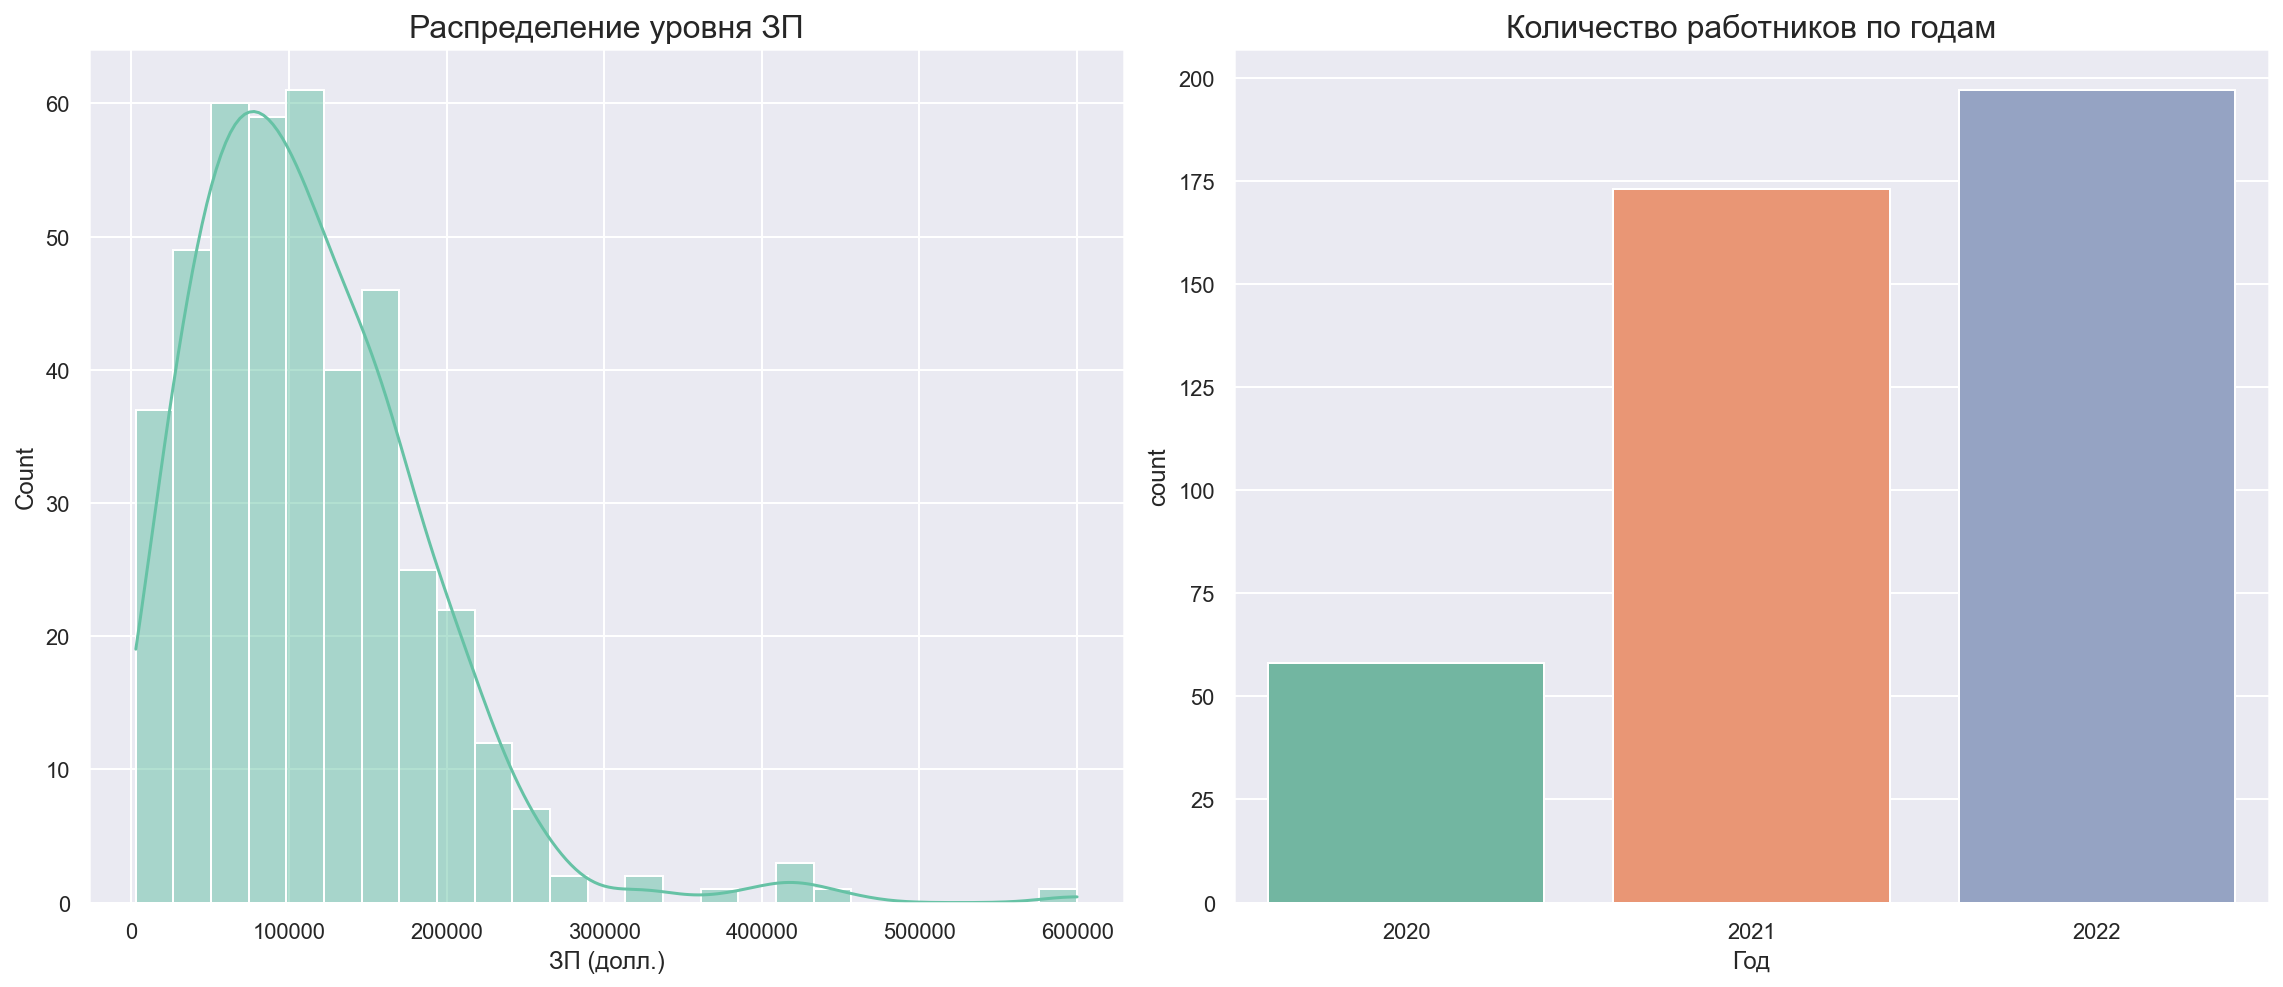

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))

sns.histplot(df, x='salary_in_usd', kde=True, ax=ax[0]);
ax[0].set_title('Распределение уровня ЗП', fontsize=16)
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.countplot(df, x='work_year', ax=ax[1])
ax[1].set_title('Количество работников по годам', fontsize=16)
ax[1].set_xlabel('Год', fontsize=12)

plt.tight_layout()
plt.show()

- Видно, что распределение зарплат отлично от нормального, так же по описательным статистикам было видно что средняя и медиана досточно сильно различаются.
- Количество работающих в сфере растет год к году

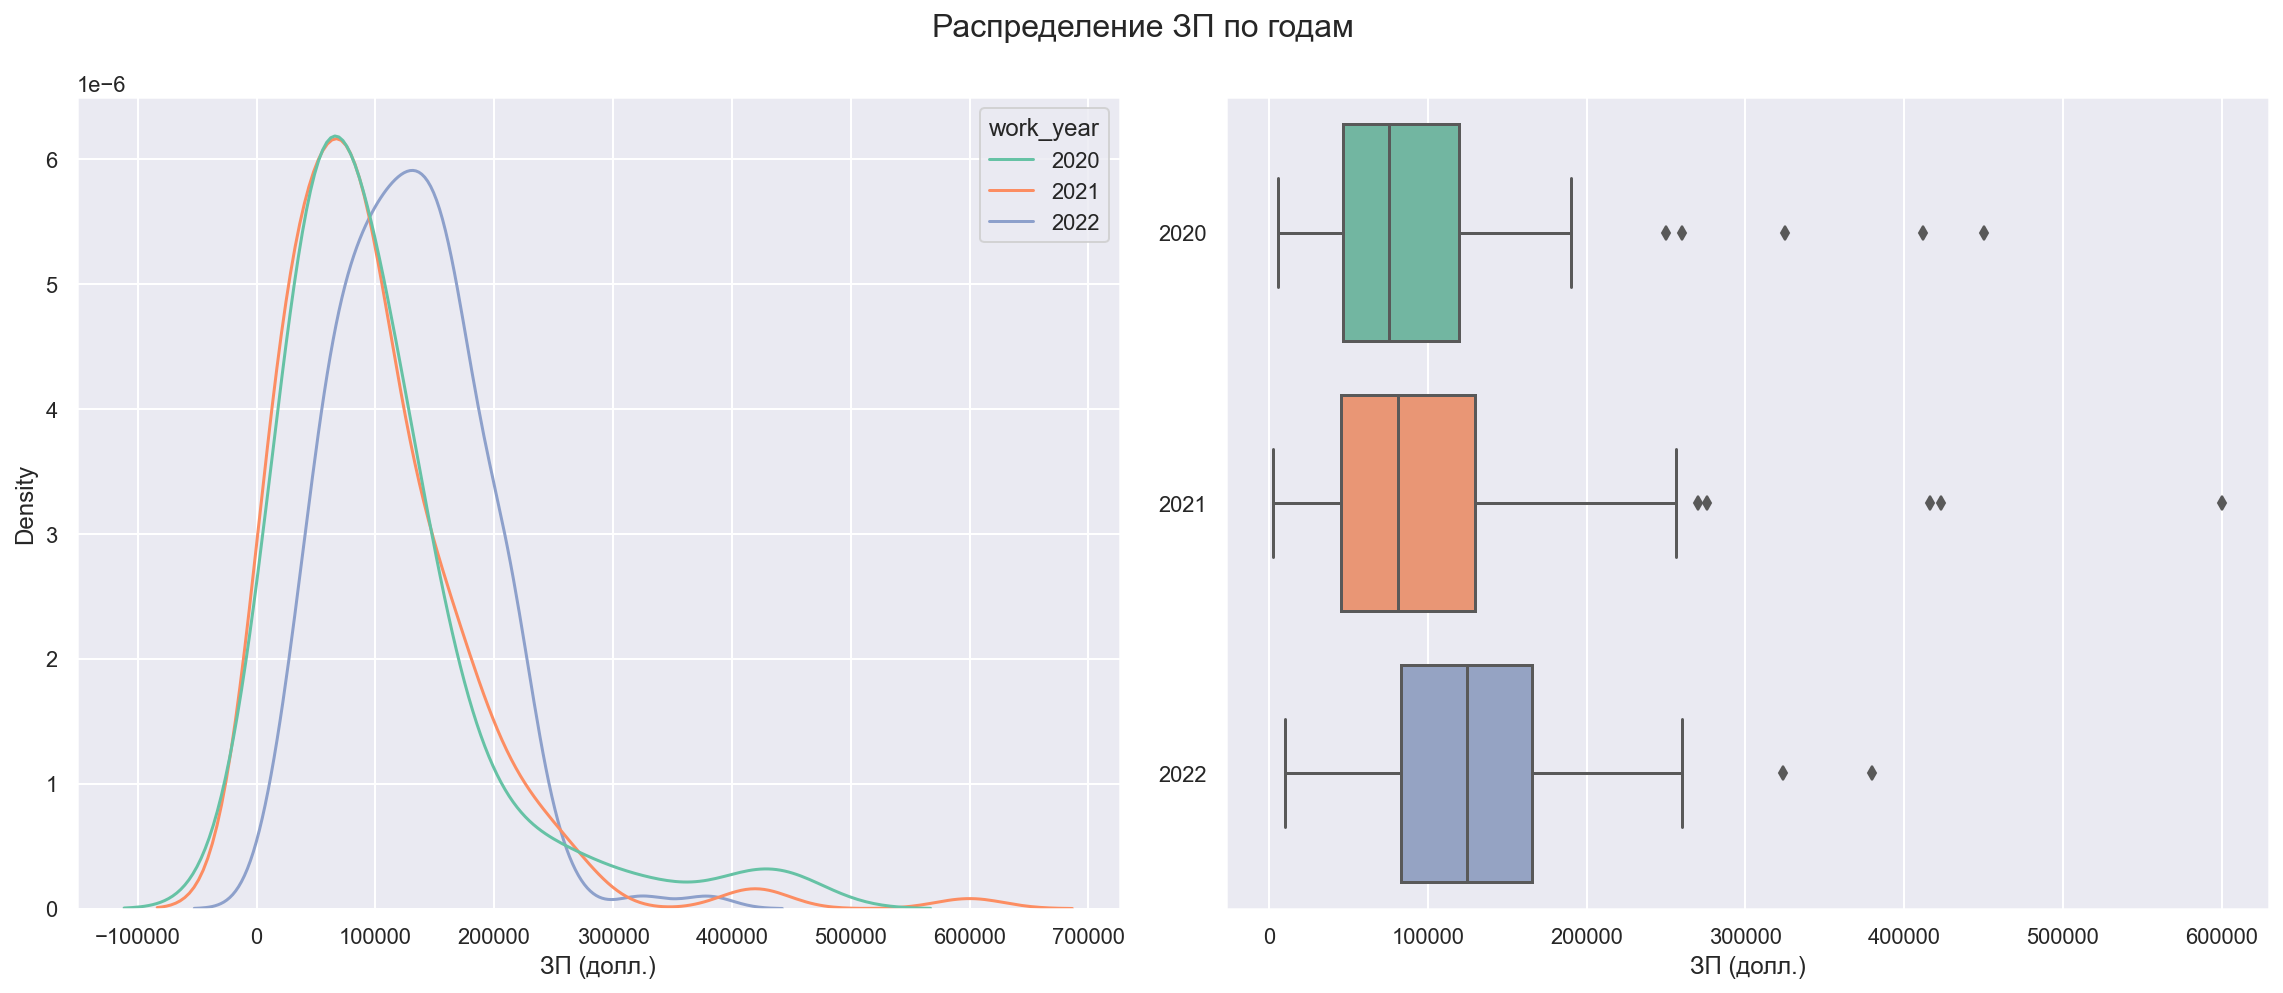

In [21]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='work_year', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='work_year', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП по годам', fontsize=16)
plt.tight_layout()
plt.show()

* По кривым плотности видно, что в 21 году ЗП практически не выросла, а вот в 22 году произошел качественных скачок ЗП, все распределение сдвинулось вправо.
* По графику коробки с усами виден рост ЗП и в частности медианной ЗП, особенно качественный рост наблюдается в 22 году.

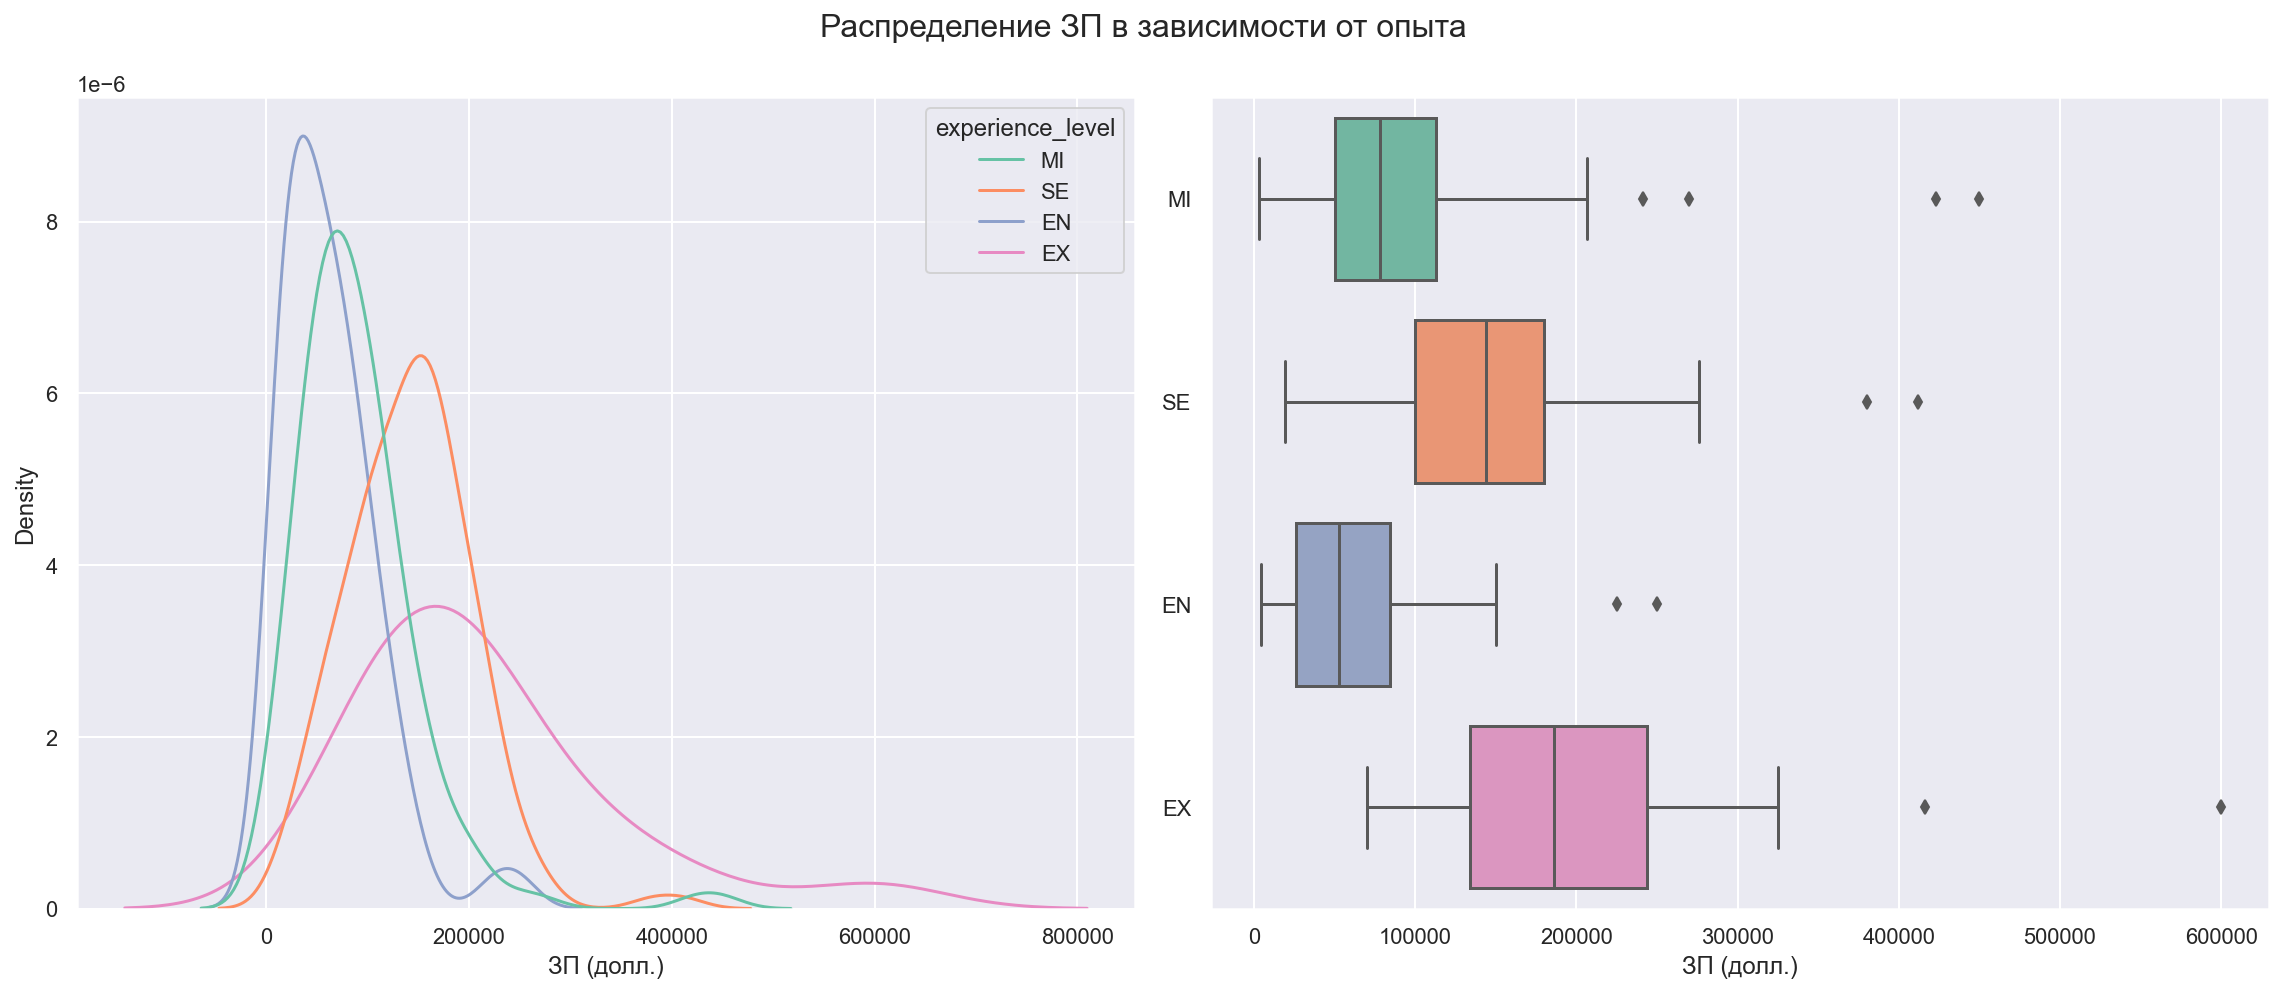

In [22]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='experience_level', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='experience_level', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от опыта', fontsize=16)
plt.tight_layout()
plt.show()

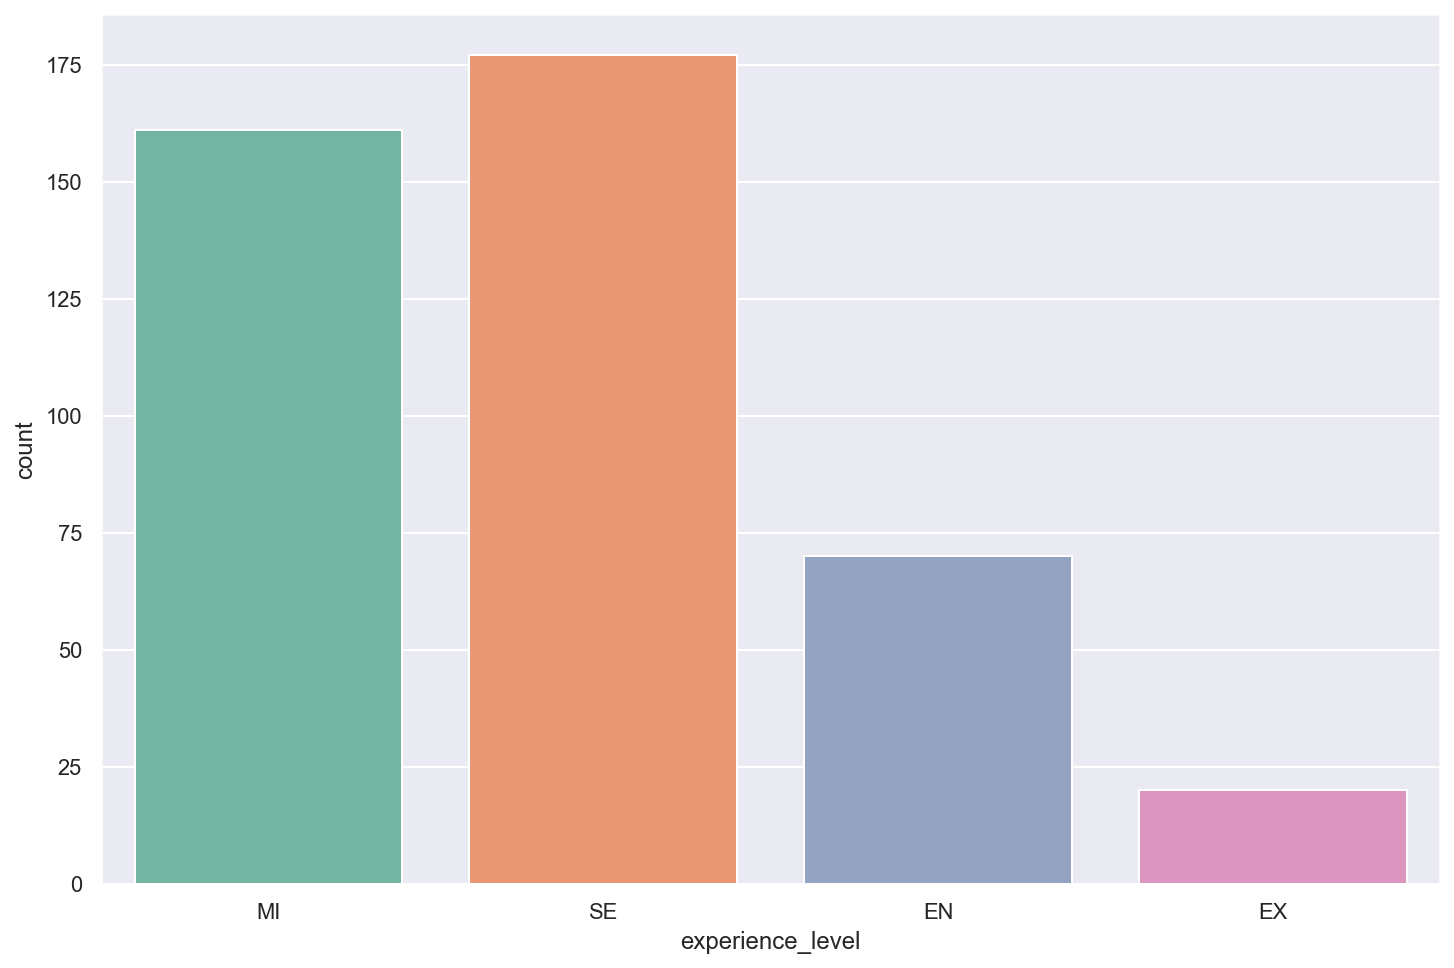

In [23]:
sns.countplot(df, x='experience_level');

* Видно, что ЗП сильно зависит от опыта.
* Классы опыта более-менее сбалансированны.

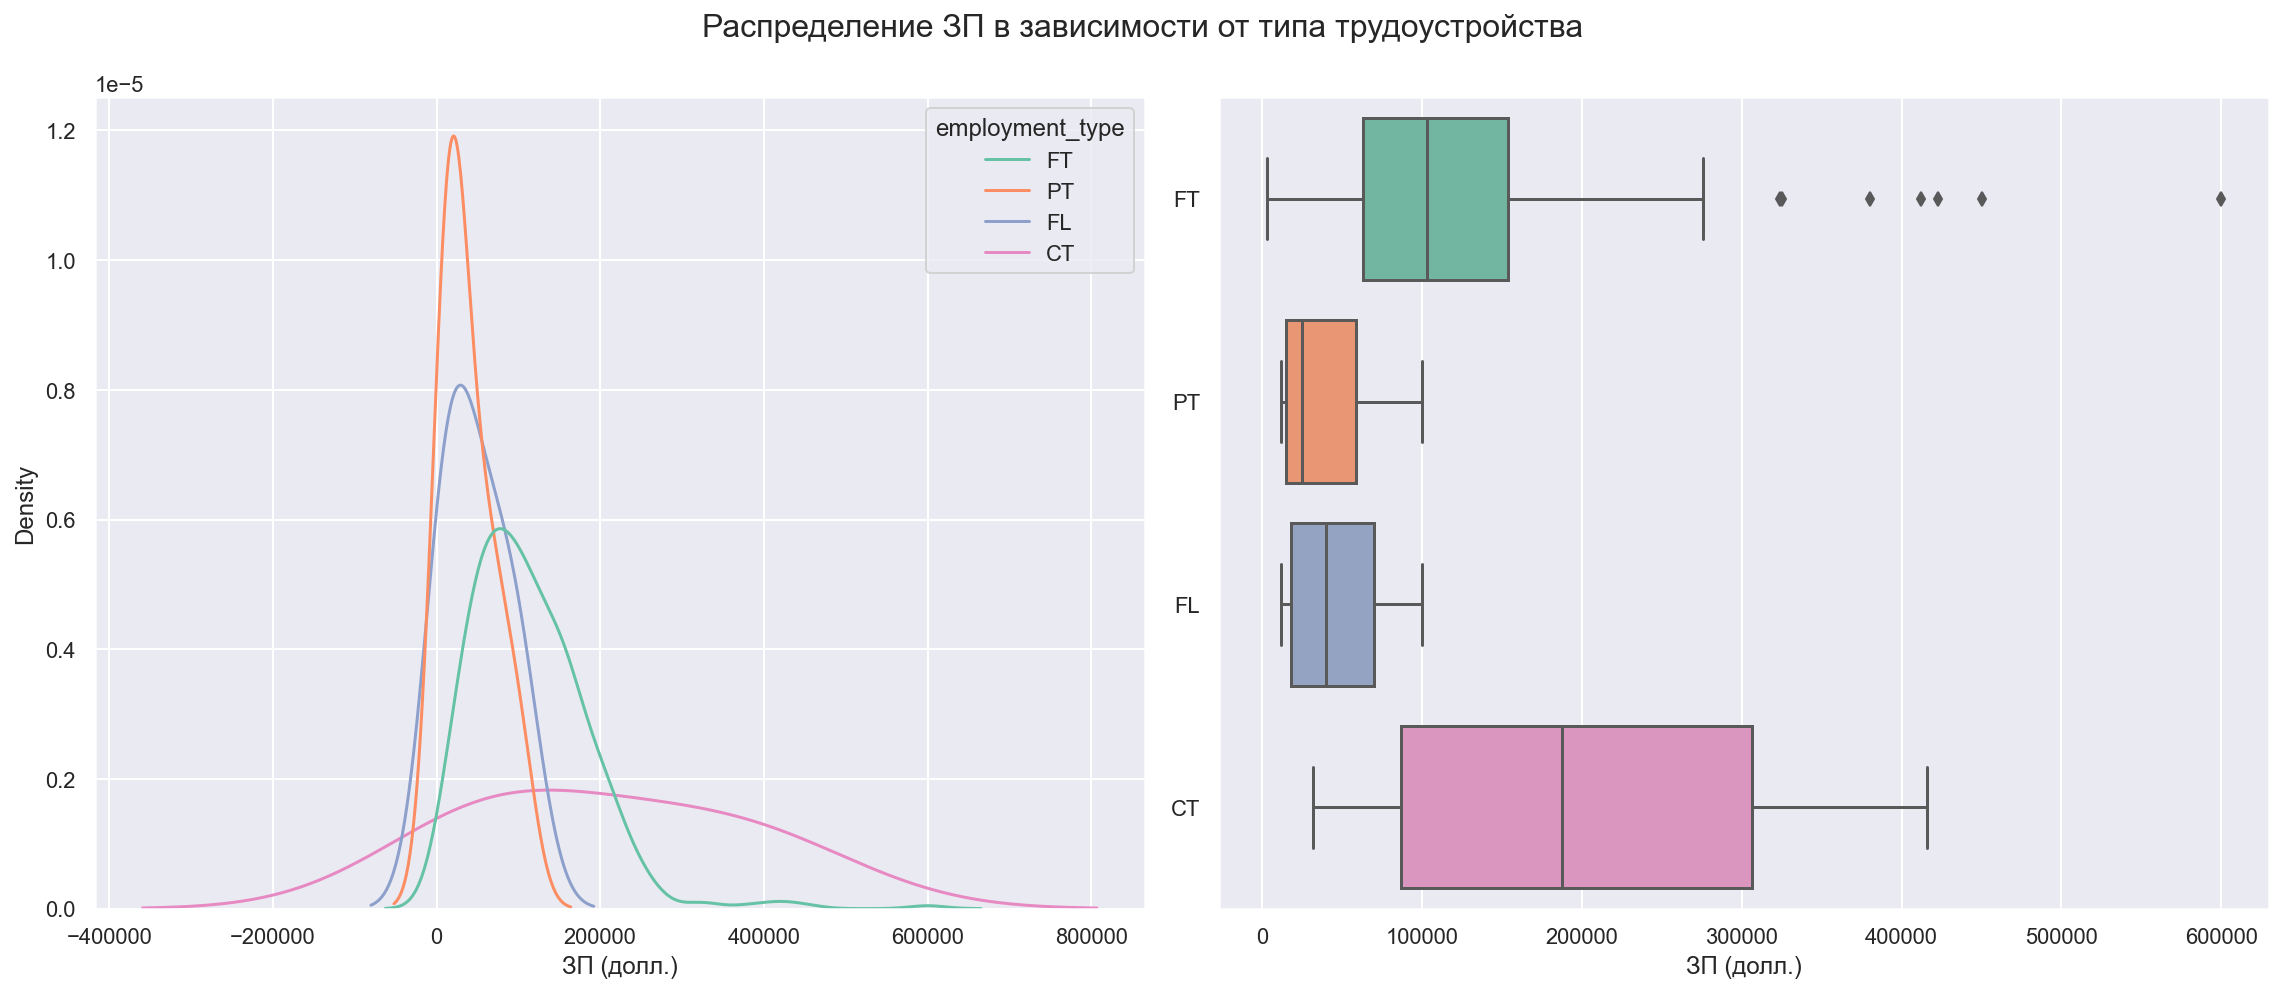

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='employment_type', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='employment_type', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от типа трудоустройства', fontsize=16)
plt.tight_layout()
plt.show()

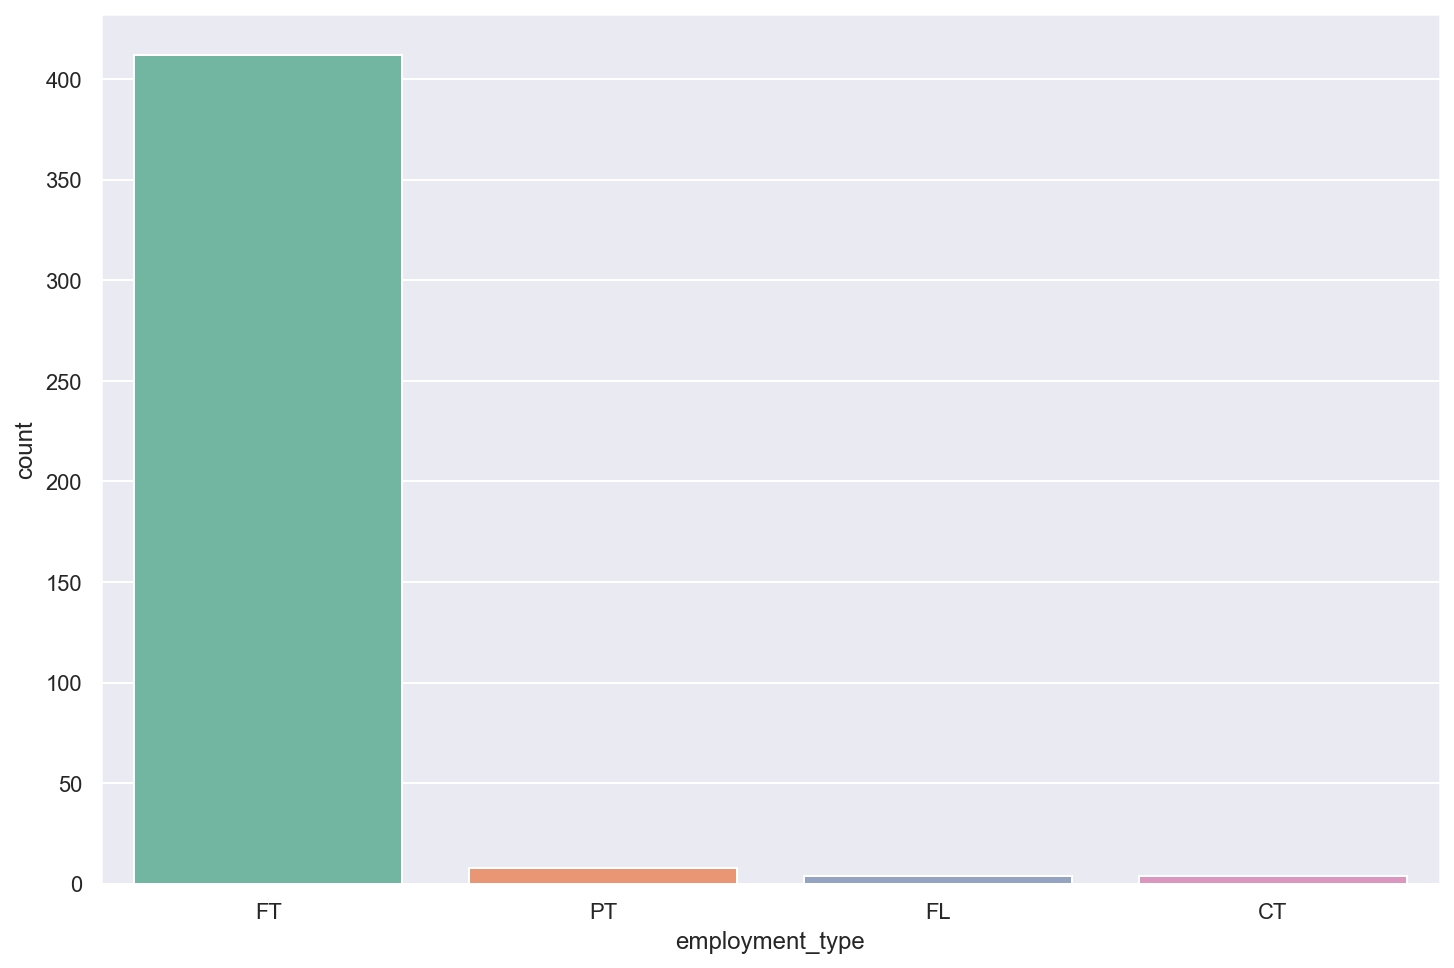

In [25]:
sns.countplot(df, x='employment_type');

* Классы типа трудоустройства сильно несбалансированны, почти все ушло в класс FT. ПРедполагается что большинство работников работают на одну компанию Full Time, проекты большие и долгосрочные.
* Медианная ЗП для FT и СT находится в одной области и сильно выше чем у PT, FL.
* При этом ЗП контрактника может сильно различаться, кробока самая большая. А на кривой плотности видны самые длинные хвосты.

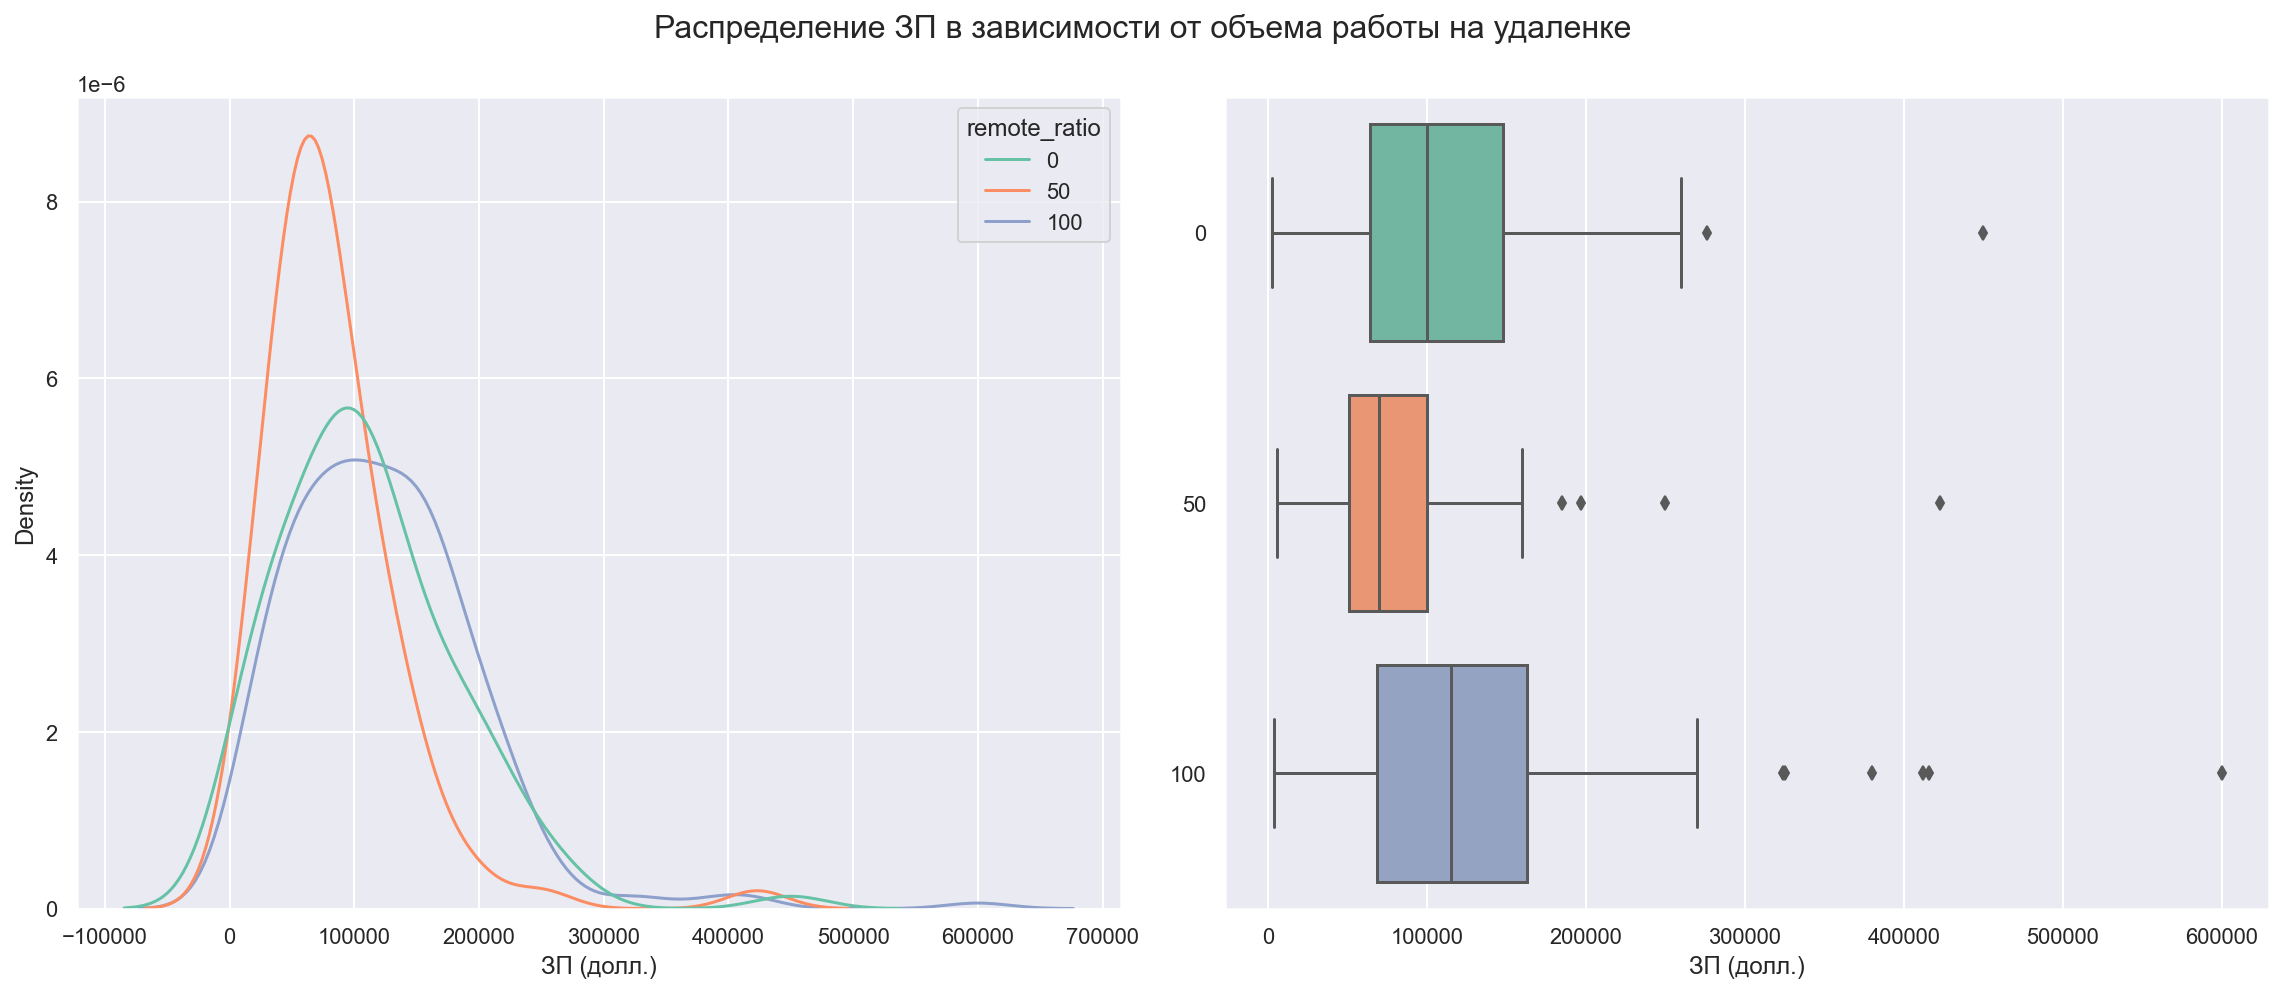

In [26]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='remote_ratio', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='remote_ratio', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от объема работы на удаленке', fontsize=16)
plt.tight_layout()
plt.show()

* Полные удаленщики и те кто работают в офисе зарабатывают примерно одинаково, а те кто 50на50 значительно меньше. Интересная закономерность.

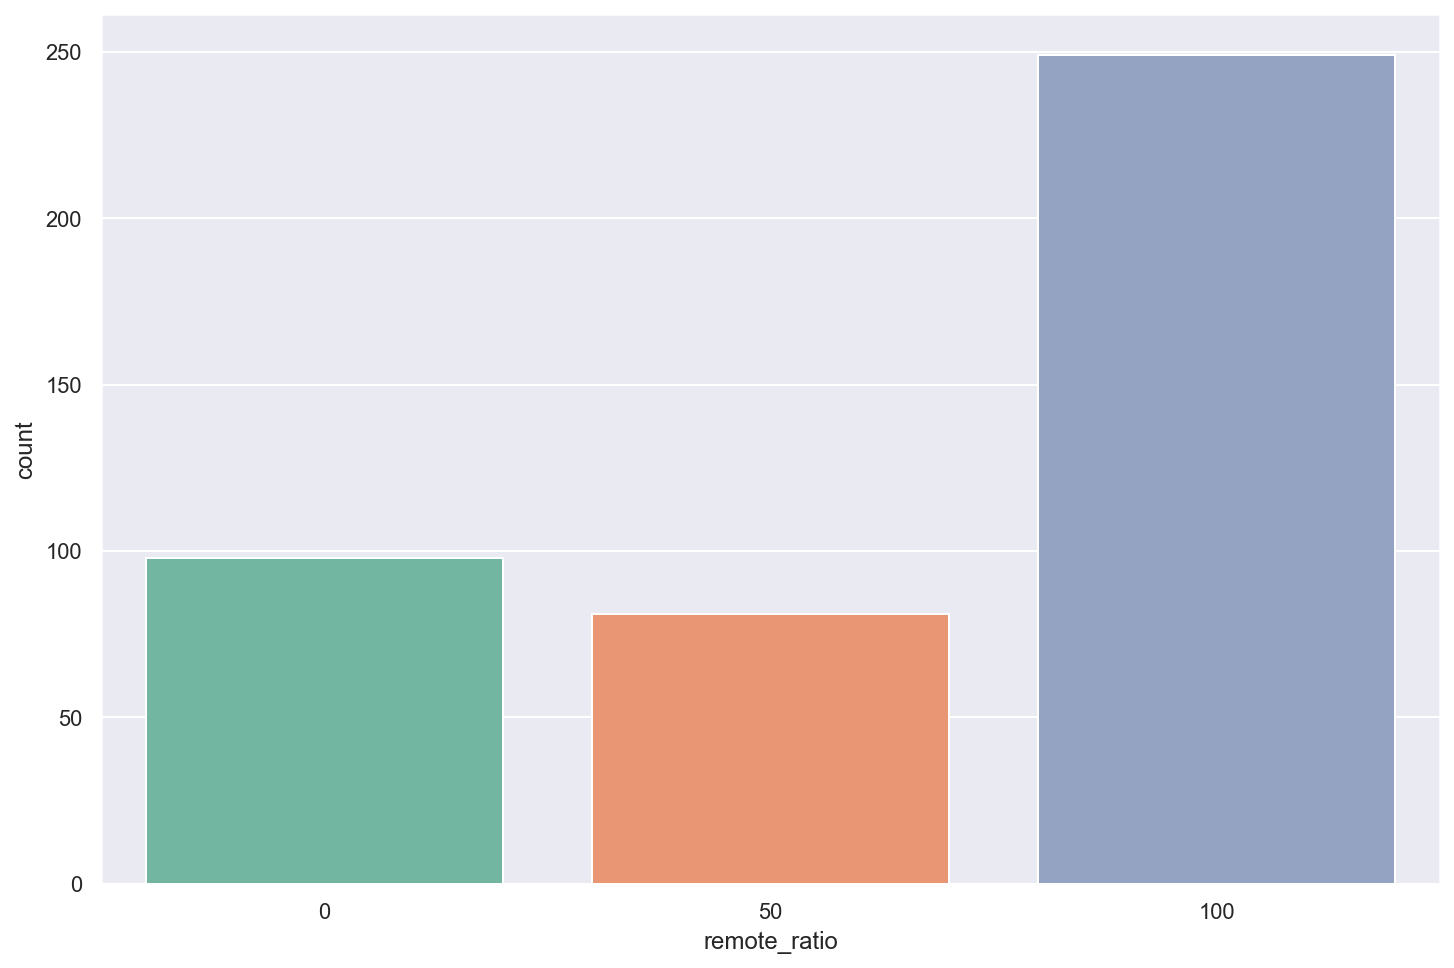

In [27]:
sns.countplot(df, x='remote_ratio');

Инетересно, что большая часть работает на полной удаленке. Самая малочисленная группа 50на50.

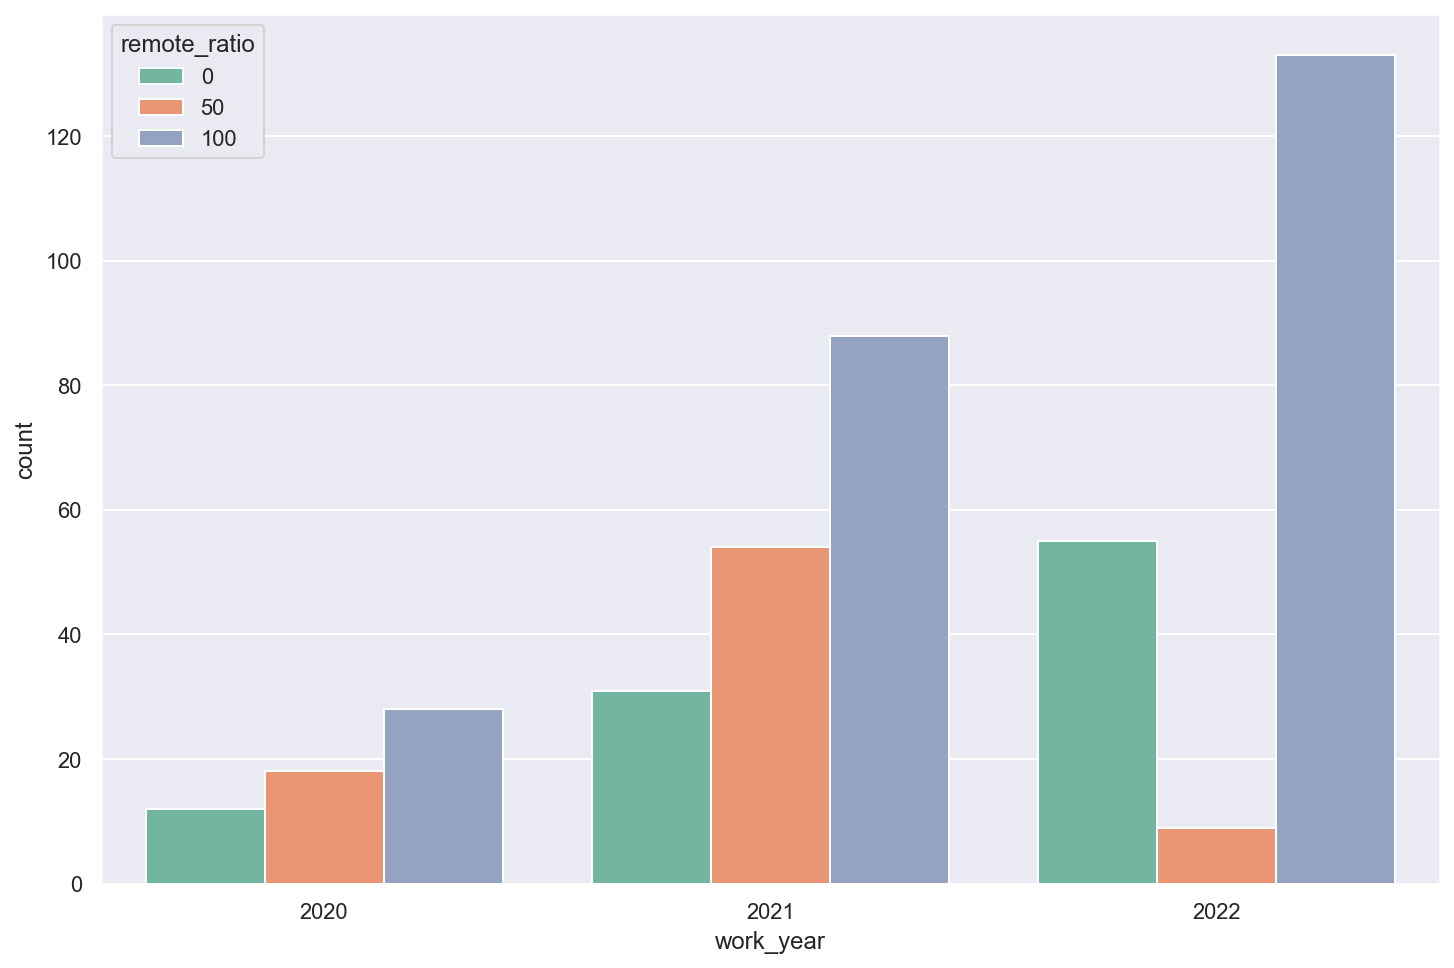

In [28]:
sns.countplot(df, x='work_year', hue='remote_ratio');

* Распределение по годам показывает что полных удаленщиков всегда было больше всего. В последний год класс тех кто работает 50на50 стал самым малочисленным.
* Думаю это связано с ковидным и пост-ковидным периодом за который у нас данные.
    - в 2020 году ковид, всех отправили на удаленку, минимум находится в офисе, чуть больше иногда приездают и самый многочисленный клас - полные удаленщики.
    - в 2021 году тенденция сохранилась, вырос лишь рынок труда и новые работники сразу нанимались на удаленку.
    - в 2022 году компании стали выходить из ковида и возвращать людей в офис, проще всего было вернуть тех, кто и так слонялся туда-сюда. Поэтому по сути сейчас большинство работает либо в офисе, либо полностью на удаленке. 50на50 отмирает и не приветствуется.

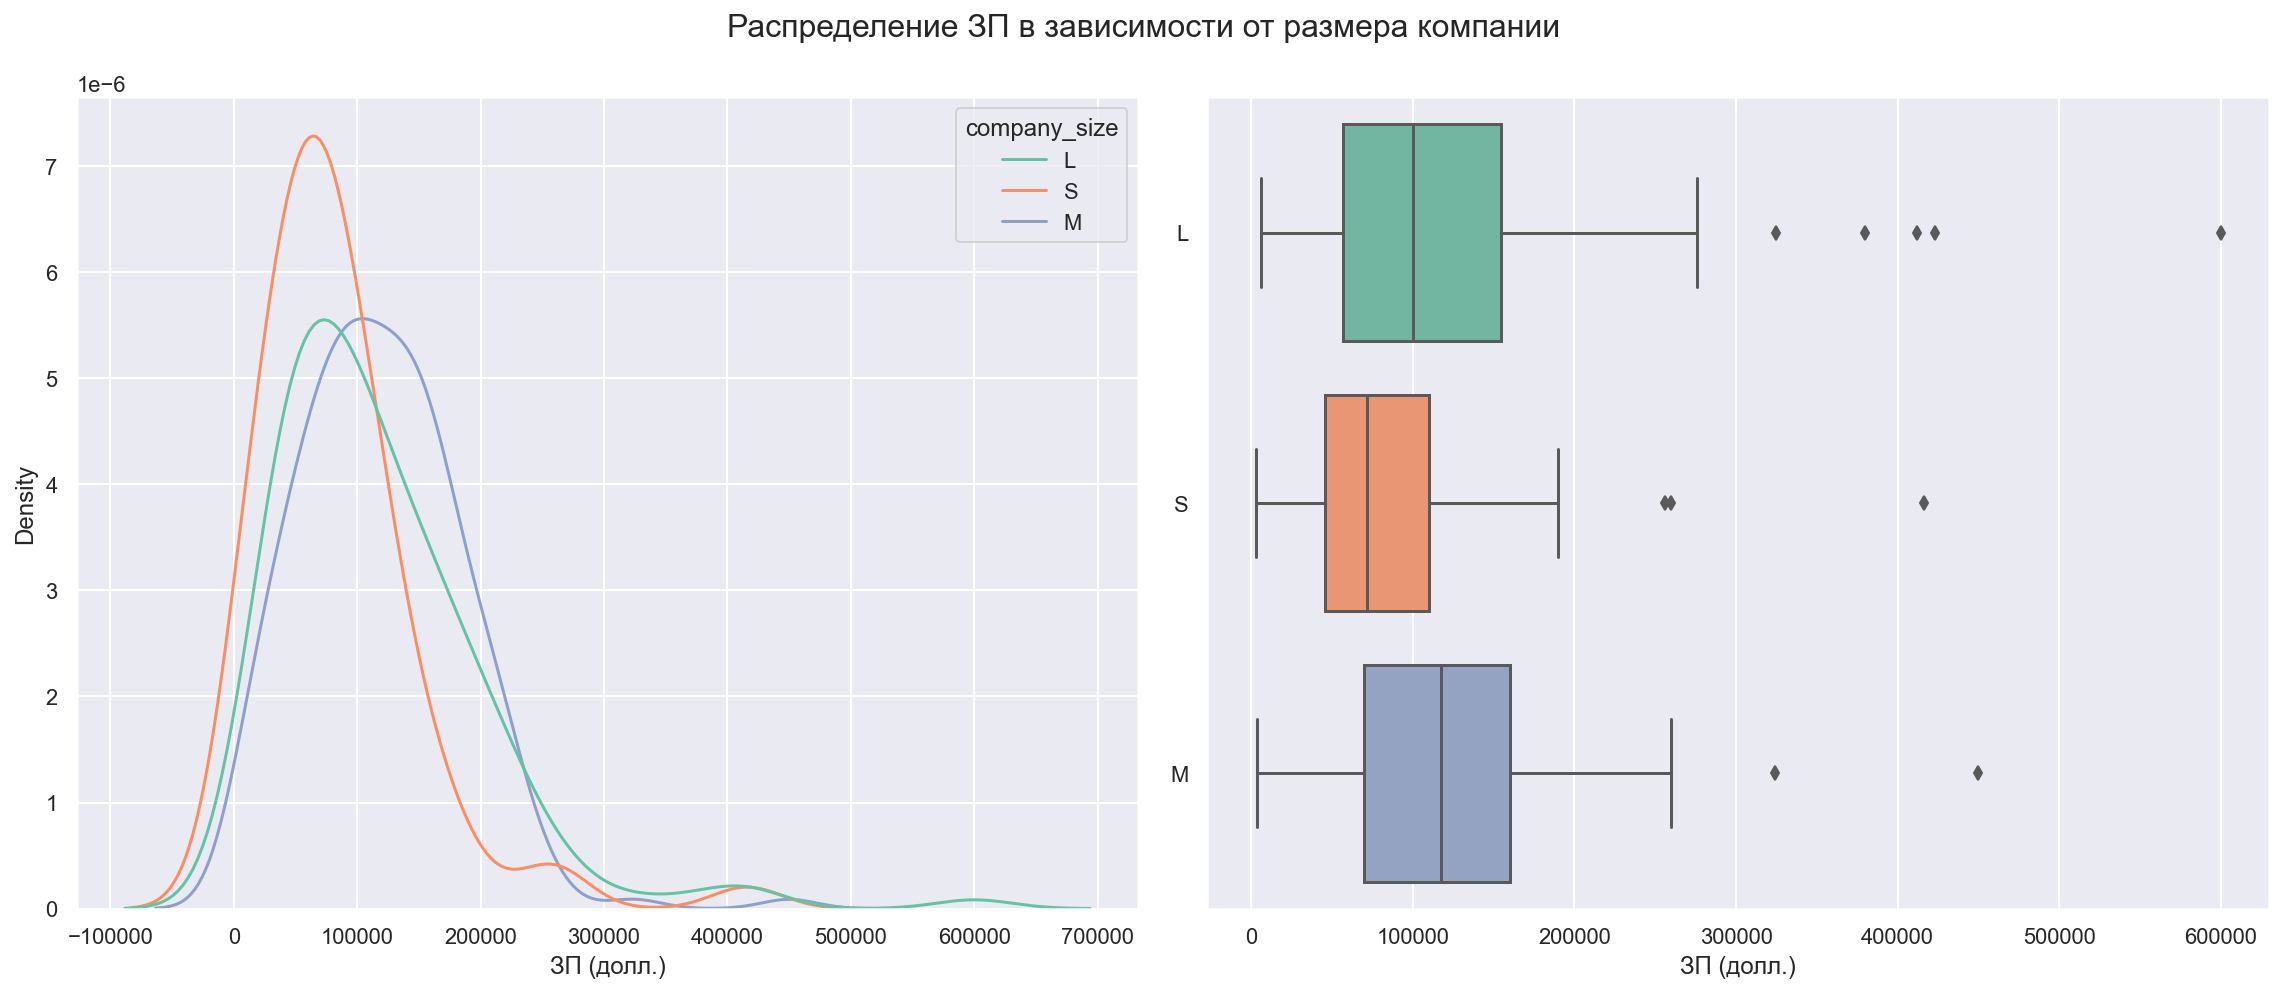

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='company_size', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='company_size', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от размера компании', fontsize=16)
plt.tight_layout()
plt.show()

* Маленькие компании платят меньше всего
* Между средними и большими разница не столь существенна

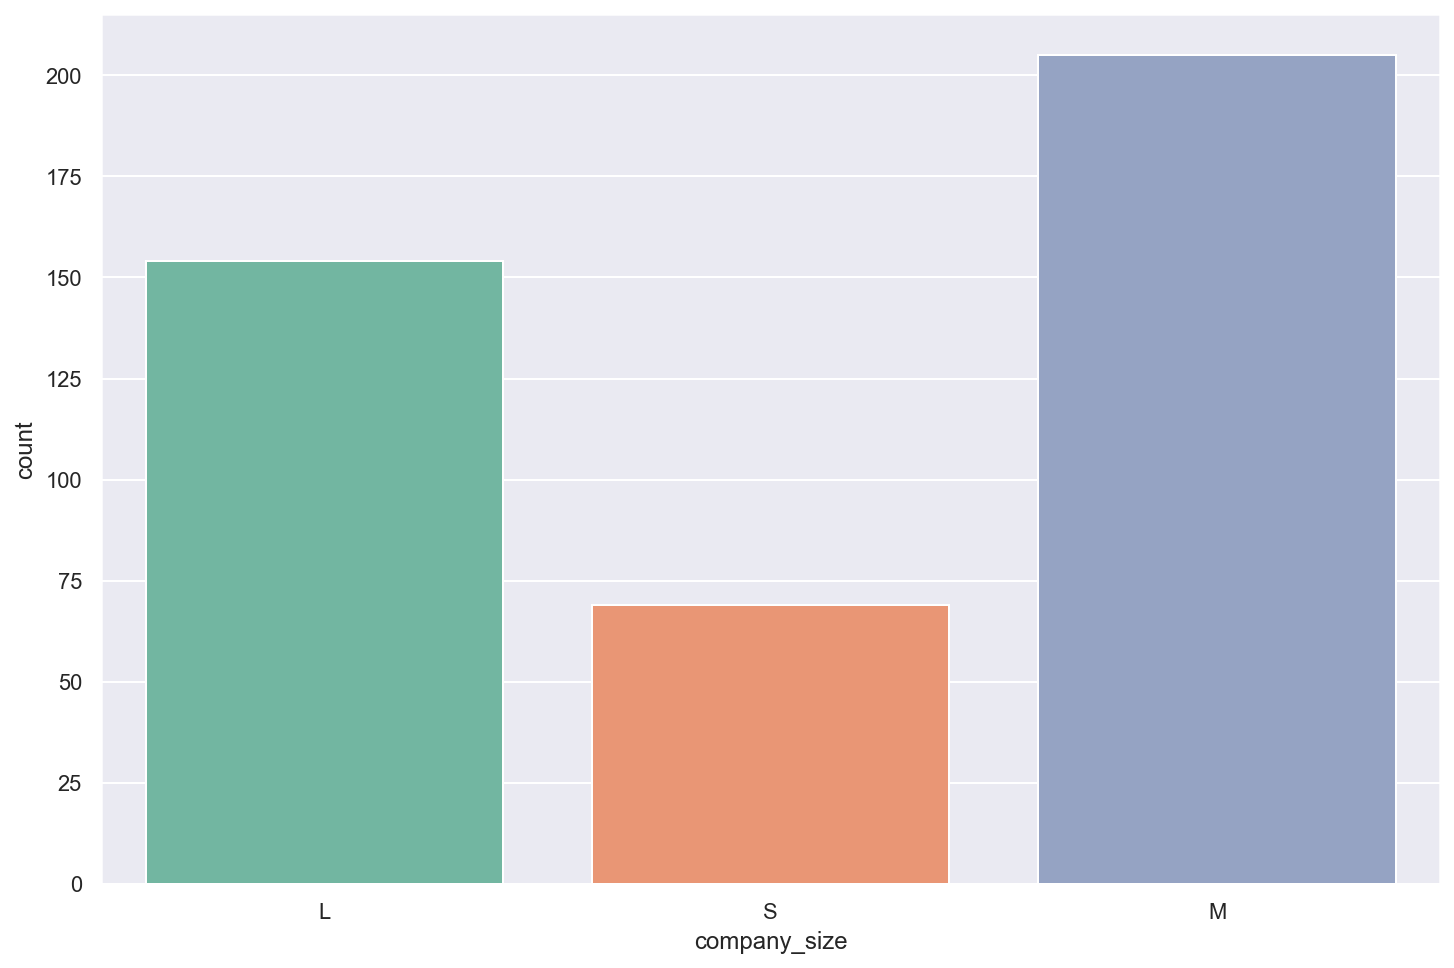

In [30]:
sns.countplot(df, x='company_size');

Классы достаточно сбалансированы, катасрофического дисбаланса нет

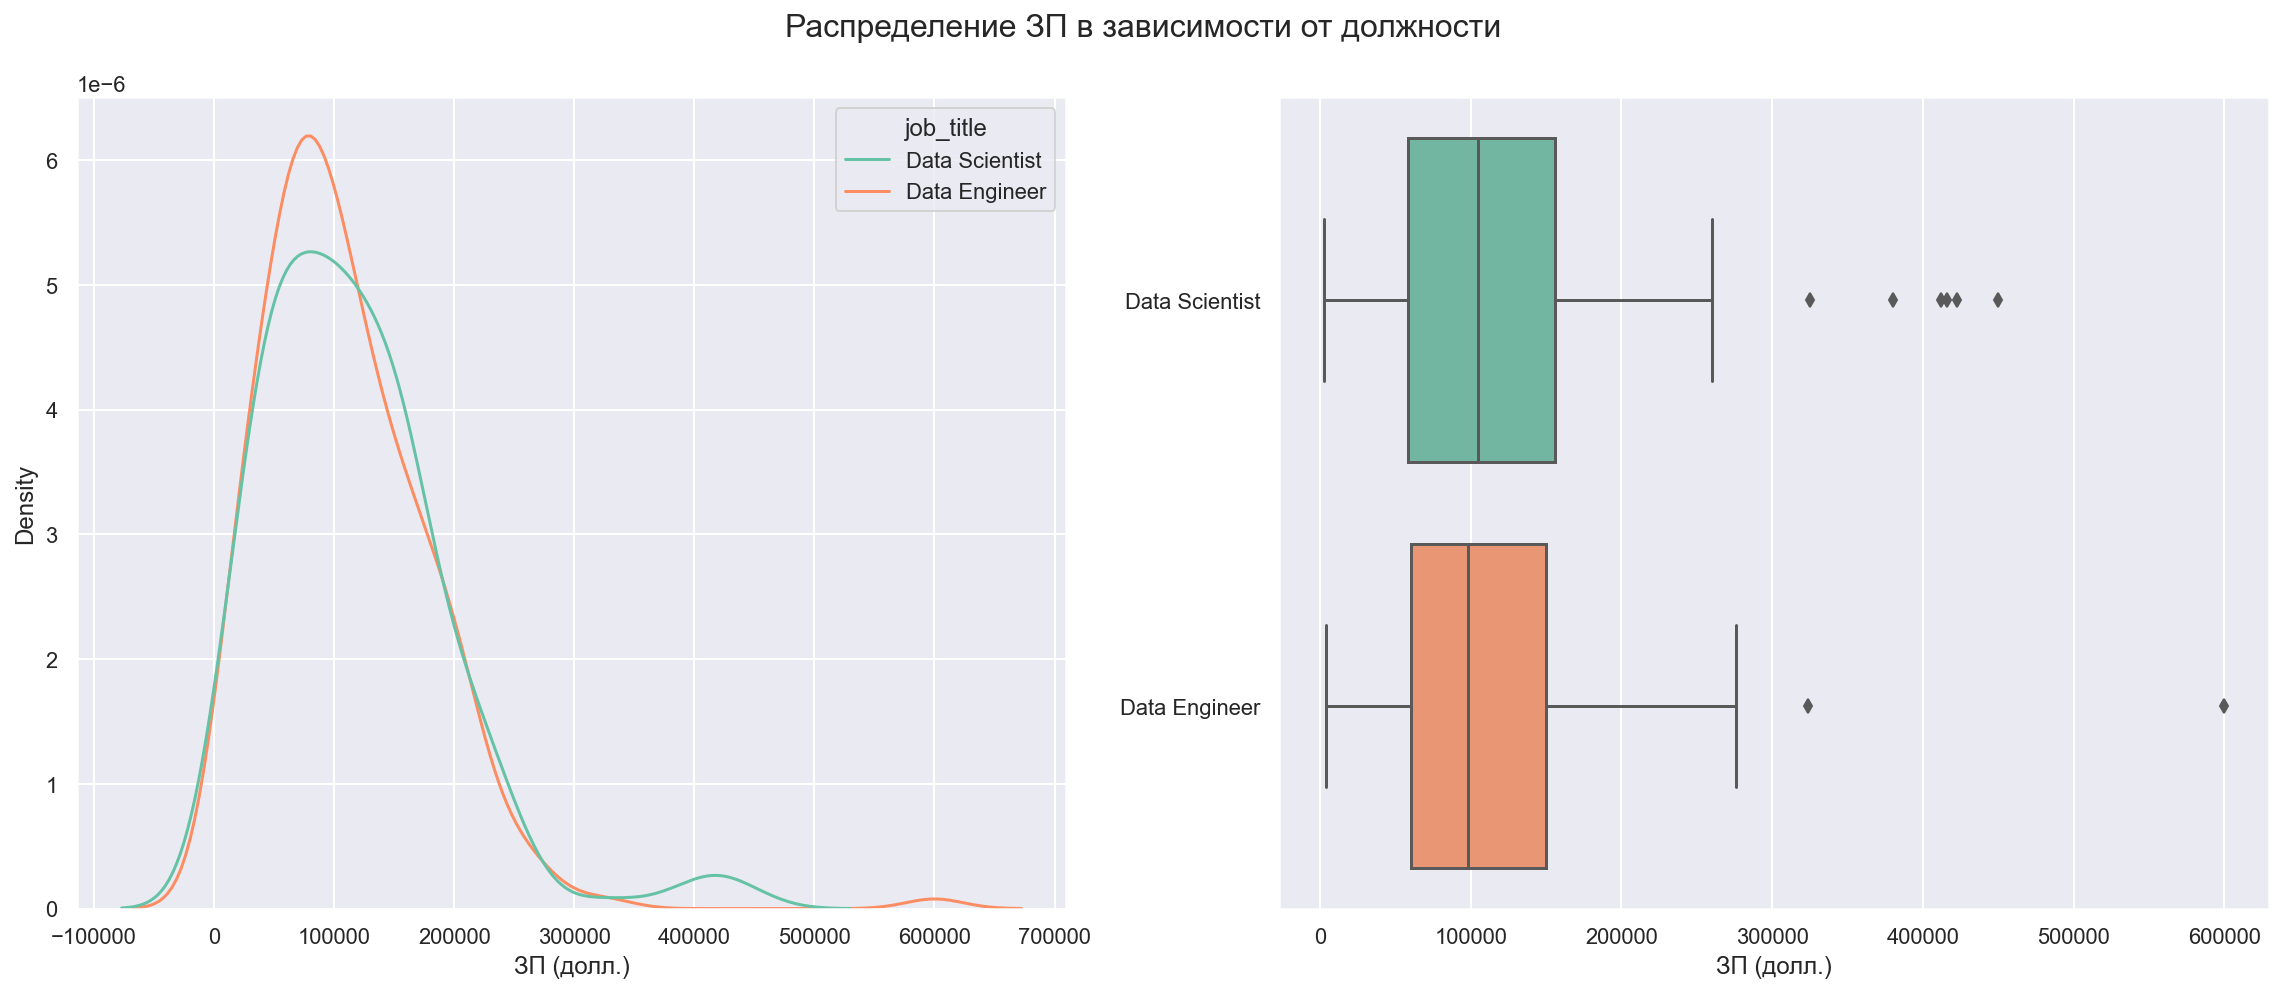

In [31]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 7))
sns.kdeplot(df, x='salary_in_usd', hue='job_title', common_norm=False, ax=ax[0])
ax[0].set_xlabel('ЗП (долл.)', fontsize=12)

sns.boxplot(df, x='salary_in_usd', y='job_title', ax=ax[1])
ax[1].set_xlabel('ЗП (долл.)', fontsize=12)
ax[1].set_ylabel('')

fig.suptitle('Распределение ЗП в зависимости от должности', fontsize=16)
plt.tight_layout()
plt.show()

* Различия в ЗП в зависимости от должности практически отсутствует